In [ ]:
#using the one layer model, because I have a 2060 super and I can do the tensor pretty quickly with gpu pipelining

In [1443]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

In [1444]:
Train_DF_label = pd.read_csv('data/training60000_labels.csv')
Train_DF = pd.read_csv('data/training60000.csv')
X = np.array(Train_DF)
Y = np.array(Train_DF_label)
X = X.T
Y = Y.T

In [1445]:
n, m = Train_DF.shape
data_matrix = np.array(Train_DF)
#combing the two because it is too much work dealing with two df

In [1446]:
np.random.seed(10041957)

In [1447]:
#initialize weight with seed 10041957, this is the time I am doing this on
#give uniform dist between 0-1 to matrix
def random_weight_bias():
    #hiden layer
    weight_h = np.random.uniform(0, 1, size=(784 * 10))
    weight_h = weight_h.reshape(10,784) - 0.5
    bias_h = np.random.uniform(0, 1, size=(10))
    bias_h = bias_h.reshape(10,1) - 0.5
    #output layer
    weight_o = np.random.uniform(0, 1, size=(10 * 10))
    weight_o = weight_o.reshape(10,10) - 0.5
    weight_o = weight_o.T
    bias_o = np.random.uniform(0, 1, size=(10))
    bias_o = bias_o.reshape(10,1) - 0.5
    return weight_h, bias_h, weight_o, bias_o

In [1448]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

In [1449]:
def logistic(input):
    #define the output of logistic output
    return 1/(1 + np.exp(-input))

In [1450]:
def d_logistic(input):
    return (np.exp(-input) / ((1 + np.exp(-input)) * (1 + np.exp(-input)))) 

In [1451]:
def softmax(input):
    #define softmax for input
    np.exp(input)/sum(np.exp(input))

In [1452]:
Train_DF_label.head(10)
labels = np.zeros((Train_DF_label.size)*10)
labels = labels.reshape((Train_DF_label.size), 10 )
labels.shape
index = 0
for I in Train_DF_label["7"]:
    labels[index][I] = 1
    index += 1
labels = labels.T

In [1453]:
print(labels.shape)

(10, 59999)


In [1454]:
def forwards(weight_h, bias_h, weight_o, bias_o, X):
    #X will be 784 size
    X0 = (weight_h.dot(X) + bias_h)
    X1 = logistic(X0)
    X2 = weight_o.dot(X1) + bias_o
    X3 = logistic(X2)
    return X0, X1, X2, X3

In [1455]:
def backs(X0,X1,X2,X3,weight_h,weight_o,X):
    #deviations
    #print(f"label shape {labels.shape}")
    X_2 = X3 - labels
    Y_2 = 1/59999  * X_2.dot(X1.T)
    #print(X_2.shape)
    X_1 = 1 / 59999 * np.sum(X_2)
    XM_1 = weight_o.dot(X_2)* d_logistic(X0)
    M1A = 1/59999  * XM_1.dot(X.T)
    M2 = 1 / 59999 * np.sum(XM_1)
    return M1A, M2, Y_2, X_1

In [1456]:
def update(weight_h, bias_h, weight_o, bias_o, dweight_h, dbias_h, dweight_o, dbias_o, alpha):
    weight_h = weight_h - alpha * dweight_h
    bias_h = bias_h - alpha * dbias_h    
    weight_o = weight_o - alpha * dweight_o  
    bias_o = bias_o - alpha * dbias_o    
    return weight_h, bias_h, weight_o, bias_o

In [1457]:
def predictions(guesses):
    return np.argmax(guesses, 0)

In [1458]:
def precision_report(predictions, Y):
    return np.sum(predictions == Y) / Y.size

In [1459]:
def gradient_descent(X, Y, alpha, target):
    t0 = time.time()
    #this gradient descent is set to stop only after you reached the target
    weight_h, bias_h, weight_o, bias_o = random_weight_bias()
    i = 1
    while True:
        X0, X1, X2, X3 = forwards(weight_h, bias_h, weight_o, bias_o, X)
        dweight_h, dbias_h, dweight_o, dbias_o = backs(X0, X1, X2, X3, weight_h, weight_o, X)
        weight_h, bias_h, weight_o, bias_o = update(weight_h, bias_h, weight_o, bias_o, dweight_h, dbias_h, dweight_o, dbias_o, alpha)
        if i % 50 == 0:
            #re calculating accuracy every few turns if too expensive so its set to test convergence every 50 epoch
            guess = predictions(X3)
            if(precision_report(guess, Y) >= target):
                t1 = time.time()
                break
        i += 1
    print(f"Reach targeted accuracy of {target * 100}% \n total time useage : {t1 - t0} sec")
    return weight_h, bias_h, weight_o, bias_o

In [1460]:
weight_h, bias_h, weight_o, bias_o = gradient_descent(X, Y, 0.50, 0.92)

Reach targeted accuracy of 92.0% 
 total time useage : 256.78408098220825 sec


In [1461]:
Validate_DF_label = pd.read_csv('data/testing10000_labels.csv')
Validate_DF = pd.read_csv('data/testing10000.csv')
X_V = np.array(Validate_DF)
Y_V = np.array(Validate_DF_label)
X_V = X_V.T
#Y_V = Y_V.T
m , n = Y_V.shape

In [1462]:
def test(X, weight_h, bias_h, weight_o, bias_o):
    A0, A00, A1, A2 = forwards(weight_h, bias_h, weight_o, bias_o, X)
    #print(f"A2 {A2}")
    return predictions(A2)

In [1463]:
def test_prediction(I, weight_h, bias_h, weight_o, bias_o, display, silence):
    validation = X_V[:, I, None]
    model_guess = test(X_V[:, I, None], weight_h, bias_h, weight_o, bias_o)
    Actual = Y_V[I]
    #if not passed display threashold, display the image for 3 seconds and then return false
    if((Actual != model_guess) and (display)):
        print(f"Following is wrong \n Model : {model_guess} \n Actual : {Actual}")
        validation_grid = validation.reshape((28, 28)) * 255
        plt.gray()
        plt.imshow(validation_grid, interpolation='nearest')
        plt.show(block=False)
        plt.pause(3)
        plt.close()
        return False
    #if passed display threashold but silence don't display
    if((Actual != model_guess) and silence):
        return False
    #if passed display threashold display only text
    elif((Actual != model_guess)):
        print(f"Following is wrong at {I} But ran out of display space \n Model : {model_guess} \n Actual : {Actual}")
        return False
    #if the test pass return true
    return True

Following is wrong 
 Model : [1] 
 Actual : [7]


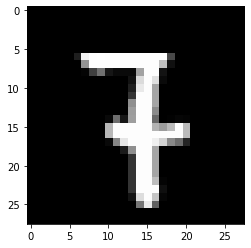

Following is wrong 
 Model : [1] 
 Actual : [2]


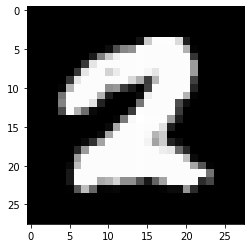

Following is wrong 
 Model : [0] 
 Actual : [8]


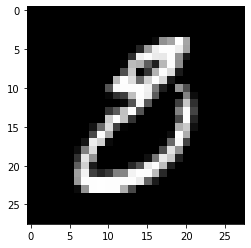

Following is wrong 
 Model : [6] 
 Actual : [3]


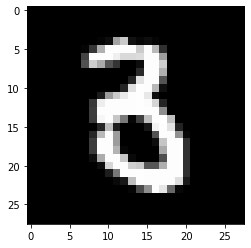

Following is wrong 
 Model : [7] 
 Actual : [3]


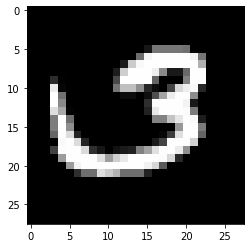

Following is wrong 
 Model : [7] 
 Actual : [3]


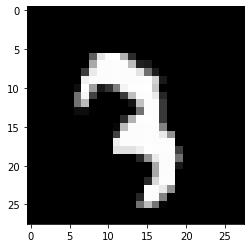

Following is wrong 
 Model : [9] 
 Actual : [4]


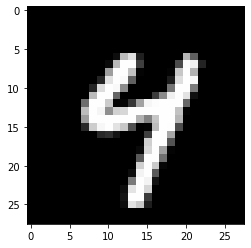

Following is wrong 
 Model : [6] 
 Actual : [8]


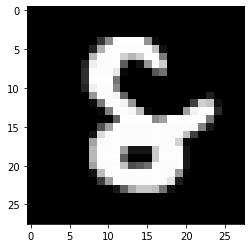

Following is wrong 
 Model : [2] 
 Actual : [3]


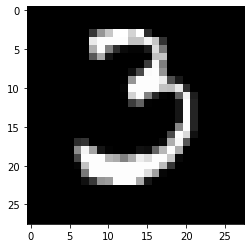

Following is wrong 
 Model : [3] 
 Actual : [2]


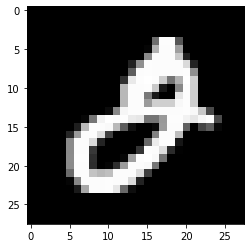

Following is wrong at 105 But ran out of display space 
 Model : [0] 
 Actual : [5]
Following is wrong at 106 But ran out of display space 
 Model : [8] 
 Actual : [3]
Following is wrong at 109 But ran out of display space 
 Model : [3] 
 Actual : [5]
Following is wrong at 118 But ran out of display space 
 Model : [0] 
 Actual : [9]
Following is wrong at 129 But ran out of display space 
 Model : [8] 
 Actual : [2]
Following is wrong at 135 But ran out of display space 
 Model : [1] 
 Actual : [2]
Following is wrong at 136 But ran out of display space 
 Model : [6] 
 Actual : [4]
Following is wrong at 161 But ran out of display space 
 Model : [6] 
 Actual : [2]
Following is wrong at 171 But ran out of display space 
 Model : [1] 
 Actual : [2]
Following is wrong at 197 But ran out of display space 
 Model : [2] 
 Actual : [8]
Following is wrong at 213 But ran out of display space 
 Model : [8] 
 Actual : [3]
Following is wrong at 220 But ran out of display space 
 Model : [8] 
 Actua

In [1465]:
T = 0
F = 0
for I in range(m):
    #change F to display more image
    #change last attribute to false to display the location of error
    display = (F < 10)
    if (test_prediction(I, weight_h, bias_h, weight_o, bias_o, display, False)):
        T += 1
    else:
        F += 1
print(f"Hits : {T} , Misses : {F} \n Model accuracy : {(T/m)*100}%")